<a href="https://colab.research.google.com/github/thishandp7/self-driving-car/blob/master/cnn_self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!git clone https://github.com/thishandp7/self-driving-car.git

fatal: destination path 'self-driving-car' already exists and is not an empty directory.


In [79]:
!ls self-driving-car/data

driving_log.csv  IMG


In [80]:
!pip3 install imgaug

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
import cv2
import random
import pandas as pd
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

In [82]:
datadir = 'self-driving-car/data'

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\center_2019_06_09_16_18_20_342.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\left_2019_06_09_16_18_20_342.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\right_2019_06_09_16_18_20_342.jpg,0.0,0.0,0.0,0.000078
1,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\center_2019_06_09_16_18_20_446.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\left_2019_06_09_16_18_20_446.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\right_2019_06_09_16_18_20_446.jpg,0.0,0.0,0.0,0.000080
2,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\center_2019_06_09_16_18_20_548.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\left_2019_06_09_16_18_20_548.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\right_2019_06_09_16_18_20_548.jpg,0.0,0.0,0.0,0.000079
3,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\center_2019_06_09_16_18_20_652.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\left_2019_06_09_16_18_20_652.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\right_2019_06_09_16_18_20_652.jpg,0.0,0.0,0.0,0.000079
4,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\center_2019_06_09_16_18_20_754.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\left_2019_06_09_16_18_20_754.jpg,C:\Users\THISHAN\Documents\@Research\SelfDrivingCar\ann-car\data\IMG\right_2019_06_09_16_18_20_754.jpg,0.0,0.0,0.0,0.000079


In [83]:
def pick_tail(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(pick_tail)
data['left'] = data['left'].apply(pick_tail)
data['right'] = data['right'].apply(pick_tail)


data.head()
print(type(data))

<class 'pandas.core.frame.DataFrame'>


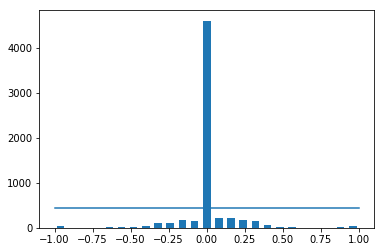

In [165]:
num_bins = 25
num_samples = 450
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (num_samples, num_samples))

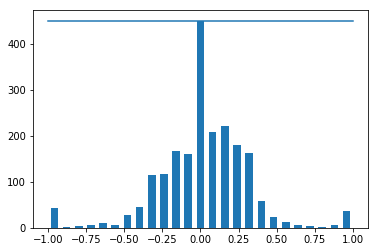

In [166]:
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[num_samples:]
  remove_list.extend(list_)
  
data_updated = data.drop(data.index[remove_list])

hist, bins = np.histogram(data_updated['steering'], num_bins)

center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data_updated['steering']), np.max(data_updated['steering'])), (num_samples, num_samples))

In [167]:
print(data_updated.iloc[8])

center      center_2019_06_09_16_18_23_131.jpg
left        left_2019_06_09_16_18_23_131.jpg  
right       right_2019_06_09_16_18_23_131.jpg 
steering   -0.240597                          
throttle    1                                 
reverse     0                                 
speed       16.0834                           
Name: 27, dtype: object


In [0]:
def load_img_steering(dir, df):
  img_path = []
  steering = []
  
  for i in range(len(df)):
    current = df.iloc[i]
    center, steering_val = current[0], current[3]
    img_path.append(os.path.join(dir, center.strip()))
    steering.append(float(steering_val))
    
  img_path = np.asarray(img_path)
  steering = np.asarray(steering)
  
  return img_path, steering

In [169]:
image_paths, steering = load_img_steering(datadir + '/IMG', data_updated)

print(image_paths[8])
print(steering[8])

self-driving-car/data/IMG/center_2019_06_09_16_18_23_131.jpg
-0.2405971


In [170]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering, test_size = 0.2, random_state=6)

print('Training samples: {}\nTest samples: {}'.format(len(X_train), len(y_valid)))


Training samples: 1656
Test samples: 415


Text(0.5, 1.0, 'Training Samples')

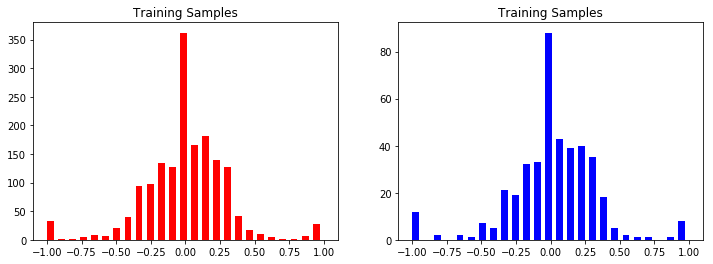

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(12 ,4))

axs[0].hist(y_train, bins=num_bins, width=0.05, color='r')
axs[0].set_title('Training Samples')

axs[1].hist(y_valid, bins=num_bins, width=0.05, color='b')
axs[1].set_title('Training Samples')

In [0]:
def zoom(img):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(img)
  return image

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x':(-0.1, 0.1), 'y':(-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [0]:
def random_img_brightness(img):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(img)
  return image

In [0]:
def random_img_flip(img, steering_angle):
  flipped = cv2.flip(img, 1)
  steering_angle = -steering_angle
  return flipped, steering_angle

In [0]:
def random_augment_img(img_path, steering_angle):
  image = mpimg.imread(img_path)
  
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = random_img_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = random_img_flip(image, steering_angle)
    
  return image, steering_angle

In [0]:
# ncols = 2
# nrows = 10

# fig, axs = plt.subplots(nrows, ncols, figsize=(15, 50))
# fig.tight_layout()

# for i in range(10):
#   random_index = random.randint(0, len(image_paths) - 1)
  
#   img = image_paths[random_index]
#   steering_angle = steering[random_index]
  
#   img_aug, steer_aug = random_augment_img(img, steering_angle)
  
#   origin_img = mpimg.imread(img)
  
#   axs[i][0].imshow(origin_img)
#   axs[i][0].set_title(steering_angle.__str__())
  
#   axs[i][1].imshow(img_aug)
#   axs[i][1].set_title(steer_aug.__str__())
  

In [0]:
def preprocess_img(img):
  cropped_img = img[60:135,: ,:]
  yuv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2YUV)
  resized_img = cv2.resize(yuv_img, (200, 66))
  normalized_img = resized_img/255
  return normalized_img

Original: (160, 320, 3)
Preprocessed: (66, 200, 3)


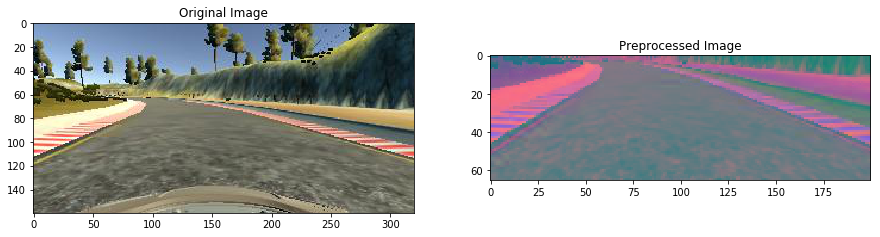

In [178]:
tmp_img = image_paths[304]

original_img = mpimg.imread(tmp_img)
preprocessed = preprocess_img(original_img)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(original_img)
axs[0].set_title('Original Image')

axs[1].imshow(preprocessed)
axs[1].set_title('Preprocessed Image')

print('Original: {}\nPreprocessed: {}'.format(original_img.shape, preprocessed.shape))

In [0]:
def batch_generator(img_paths, steering_angles, batch_size, isTraining):

  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(img_paths) - 1)
      
      if isTraining:
        img, steer = random_augment_img(img_paths[random_index], steering_angles[random_index])
        
      else:
        img = mpimg.imread(img_paths[random_index])
        steer = steering_angles[random_index]
        
      img = preprocess_img(img)
    
      batch_img.append(img)
      batch_steering.append(steer)
    
    yield (np.asarray(batch_img), np.asarray(batch_steering))
  

Text(0.5, 1.0, '0.0')

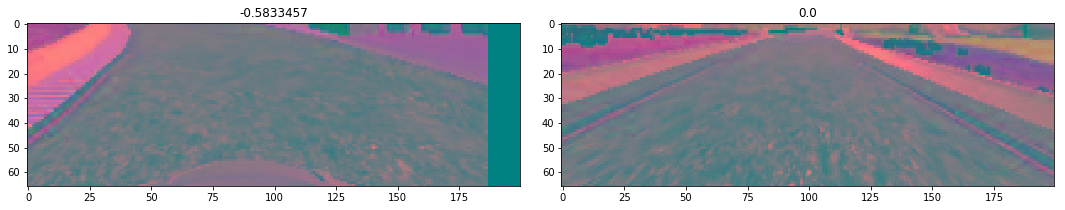

In [180]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))


fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title(y_train_gen[0].__str__())

axs[1].imshow(X_valid_gen[0])
axs[1].set_title(y_valid_gen[0].__str__())

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  model.compile(Adam(lr = 1e-4), loss='mse')
  
  return model

In [182]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)              0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """


In [183]:
h = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                        steps_per_epoch=300, 
                        epochs=10, 
                        validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                        validation_steps=200, 
                        verbose=1, 
                        shuffle=1)

Epoch 1/10
300/300 [==============================] - 115s 384ms/step - loss: 0.0995 - val_loss: 0.1014
Epoch 2/10
300/300 [==============================] - 112s 373ms/step - loss: 0.0824 - val_loss: 0.0983
Epoch 3/10
300/300 [==============================] - 112s 372ms/step - loss: 0.0777 - val_loss: 0.0856
Epoch 4/10
300/300 [==============================] - 112s 373ms/step - loss: 0.0764 - val_loss: 0.0839
Epoch 5/10
300/300 [==============================] - 112s 373ms/step - loss: 0.0752 - val_loss: 0.0770
Epoch 6/10
300/300 [==============================] - 112s 374ms/step - loss: 0.0680 - val_loss: 0.0719
Epoch 7/10
300/300 [==============================] - 112s 374ms/step - loss: 0.0672 - val_loss: 0.0634
Epoch 8/10
300/300 [==============================] - 112s 373ms/step - loss: 0.0656 - val_loss: 0.0572
Epoch 9/10
300/300 [==============================] - 112s 374ms/step - loss: 0.0619 - val_loss: 0.0500
Epoch 10/10
300/300 [==============================] - 113s 376m

Text(0.5, 1.0, 'Loss')

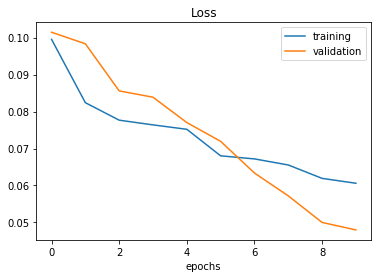

In [184]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.xlabel('epochs')
plt.legend(['training', 'validation'])
plt.title('Loss')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files

In [0]:
files.download('model.h5')